In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import functions

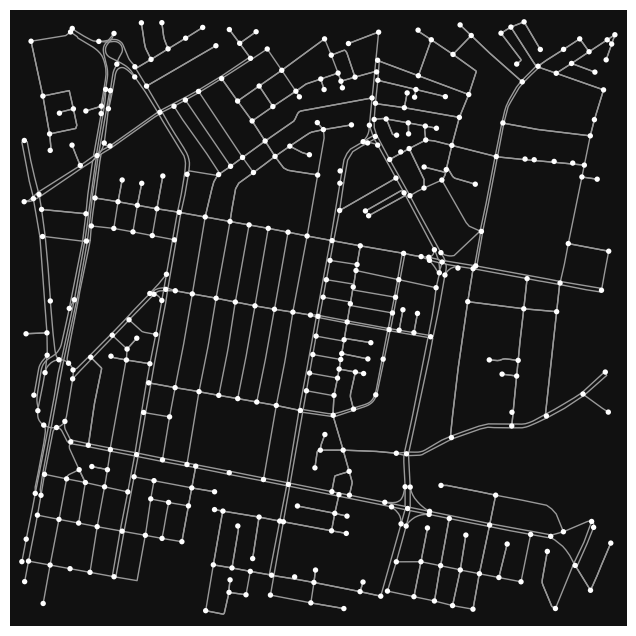

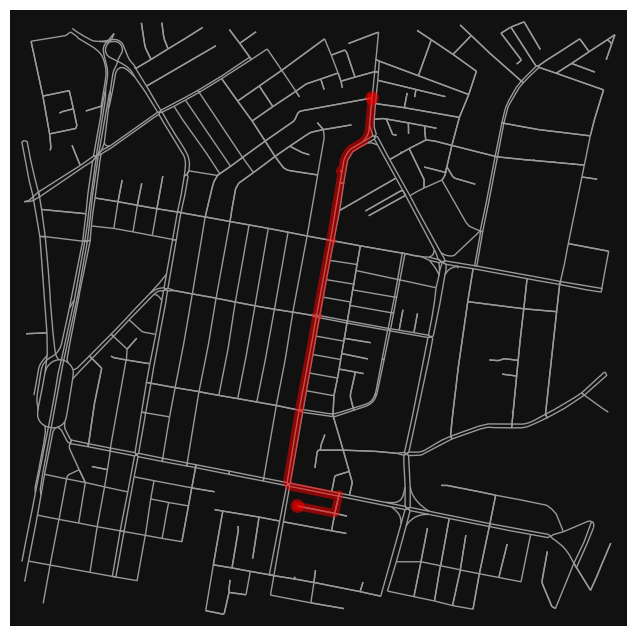

In [2]:
# This location is 4km round the carlina park: 
G = ox.project_graph(ox.graph_from_point((-0.16509, -78.47888 ), dist=1000, network_type='drive'))
G = ox.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True)

# Plotting the map: 
ox.plot_graph(G)

# plot route from pos 3 tests 
route00_G3 = nx.shortest_path(G, 79, 178 ) # 18-36 ya  salio  18-54 ya salio ,  67-54 si sale , 12-45 si sale

#Plot routes  
fig, ax = ox.plot_graph_route(G, route00_G3, route_linewidth=6, node_size=0)

In [3]:
# check the info og the graph
df = nx.to_pandas_edgelist(G)

In [24]:
# def simulation function 

# get list of nodes 
list_nodes = list(G.nodes)

# get dictionary with geocordinates of each of the nodes 

coordiantes = functions.get_geo_coordinates(G)

# defining initial and final node
initial_node = list_nodes[18]
final_node = list_nodes[54]

# loop to finde the path: 

node_i = initial_node 

# to store the routes:
route= {}

path = []

# bug list
bug_list = []

# no exit list 
no_exit_list = []


while node_i != final_node:

    # store all nodes the agent pass through: 
    path.append(node_i)
    
    # measure the angle and distnac between the node_i and the destination node
    angle_i = functions.get_angle( coordiantes[ node_i ], coordiantes[ final_node] )
    dist_i = functions.get_distance( coordiantes[ node_i ], coordiantes[ final_node] ) 

    # get the neighbours of the node. The neighbours are directed nodes
    neighbors = list(G.neighbors(node_i))

    # get probality of pick a given neighbour
    factors = {}

    for node in neighbors :
        # measure angle and dist of neighbors towards final node 
        angle_neighbor = functions.get_angle( coordiantes[ node ], coordiantes[ final_node] )
        dist_neighbor = functions.get_distance( coordiantes[ node ], coordiantes[ final_node] )

        # get the length of the road

        lenght = functions.get_length (node_i , node, G)
        
        # calculate the probability of picking a node 
        factors[node] = functions.get_factor(dist_neighbor , angle_neighbor , dist_i , angle_i , 0.6, 0.4 )

    # get probabilities
    proba_dic = functions.get_probability(factors)


    print("estoy en el nodo  ", node_i, " mis opciones son : ", proba_dic)

    # list of probable nodes_id: 
    list_proba = list(proba_dic.keys())

    # countador de cuantas veces paso por un nodo 
    repeticions = path.count(node_i)

    for node in list_proba:
        counter = path.count(node)
        if node in path:
            proba_dic[node] = proba_dic[node]*0.4
            if counter > 2:
                 proba_dic[node] = proba_dic[node]*(0.4**counter)


    # if i have pas more than two times by a node 
    if repeticions > 2:
        
        # sotre node_i in wich bug is produced 
        bug_node = node_i
        bug_list.append(node_i)
        print("bugg en el nodo : " , bug_node )

        # count how many times a bug node has been pass through.
        counter = bug_list.count(node_i)

        if counter >= 3:
            vecinos_i = list(G.neighbors(node_i))
            for vecino in vecinos_i:
                if vecino in  bug_list:
                    route[bug_node][vecino] = 0.0
                    proba_dic[vecino] = route[bug_node][vecino]
                    print("me quedo en el nodo: " , node_i, "acualice probabiliades: ", proba_dic)
                    #print(route)
            #break
        
    # check for node with no exit i.e no neigbors 
    if len(neighbors) == 0:
        # store in route 
        print("estoy en el nodo " , node_i , "no hay salida")
        no_exit_node = node_i
        route[no_exit_node] = {}
        no_exit_list.append(no_exit_node)

        # acutalizo la posicion al nodo anterior
        node_i= path[-2]

        # check neihbours
        vecino_j = list(G.neighbors(node_i))

        # acualizo la proabilidad de volver al nodo sin salida a 0
        for vecino in vecino_j:
            if vecino in no_exit_list:
                route[node_i][no_exit_node] = 0.0
                proba_dic = route[node_i]
                print("volvi al nodo: ", node_i, "se acutliazo las lista de probilidades a : " ,proba_dic)
        #break
                
    # check if the node has no posible routes to the destination
    no_options = all( options == 0 for options in proba_dic.values())       
    if no_options:
        position = path.index(node_i)
        no_options_node = node_i
        no_exit_list.append(node_i)
        print("ninguno de los caminos posibles es correcto")
        print("regreso al nodo", path[position - 1 ])
        node_i =  path[position - 1 ]
        route[node_i][no_options_node] = 0.0
        proba_dic = route[node_i]
        
        # checkear que no vuelva a una ruta sin salida: 
        vecino_z = vecino_j = list(G.neighbors(node_i))
        for vecino in vecino_z:
            if vecino in no_exit_list:
                position_i = path.index(node_i)
                node_j = path[position_i -1]
                print("debo regresar al node " , node_j, " no debo ir a ", node_i)
                route[node_j][node_i] = 0.0
                proba_dic = route[node_j]
                print(proba_dic)
        #break

    # stop simulation if bug 
    if repeticions > 15:
        print(" ERROR: el nodo " , node_i ," se repite mas de 15 veces")
        break

    # add to route:
    route[node_i] = proba_dic
    
    # ge the node id with max probability
    node_id = max(proba_dic , key= proba_dic.get)

    # get the max probability    
    Proba = proba_dic[node_id]
        
    print("estoy en el nodo: " , node_id)

    # update position
    node_i = node_id

route[final_node] = {final_node:1.0}

estoy en el nodo   18  mis opciones son :  {17: 1.0}
estoy en el nodo:  17
estoy en el nodo   17  mis opciones son :  {16: 0.36304475940574726, 14: 0.30312267539737897, 18: 0.3338325651968736}
estoy en el nodo:  16
estoy en el nodo   16  mis opciones son :  {14: 0.2968432231875266, 19: 0.38612823409150276, 17: 0.3170285427209706}
estoy en el nodo:  19
estoy en el nodo   19  mis opciones son :  {16: 1.0}
estoy en el nodo:  16
estoy en el nodo   16  mis opciones son :  {14: 0.2968432231875266, 19: 0.38612823409150276, 17: 0.3170285427209706}
estoy en el nodo:  14
estoy en el nodo   14  mis opciones son :  {12: 0.25782383853666746, 16: 0.3927872414791623, 17: 0.3493889199841704}
estoy en el nodo:  12
estoy en el nodo   12  mis opciones son :  {13: 0.4330974839719752, 14: 0.5669025160280249}
estoy en el nodo:  13
estoy en el nodo   13  mis opciones son :  {15: 1.0}
estoy en el nodo:  15
estoy en el nodo   15  mis opciones son :  {4: 0.5062081725590458, 36: 0.4937918274409541}
estoy en el n

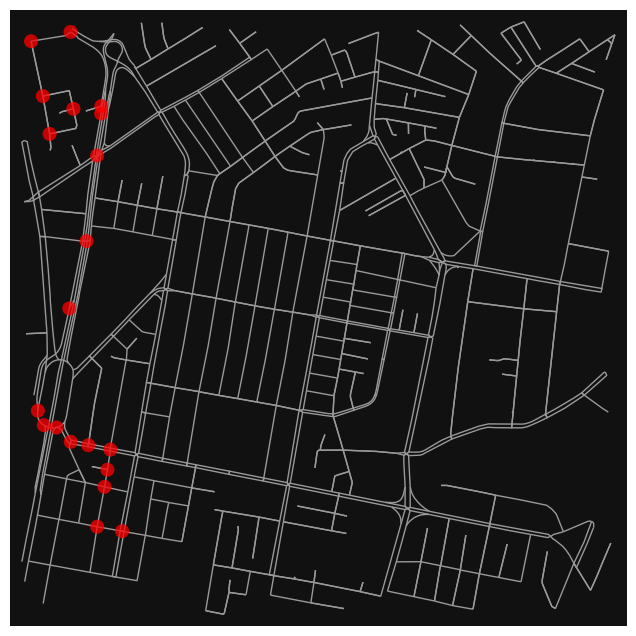

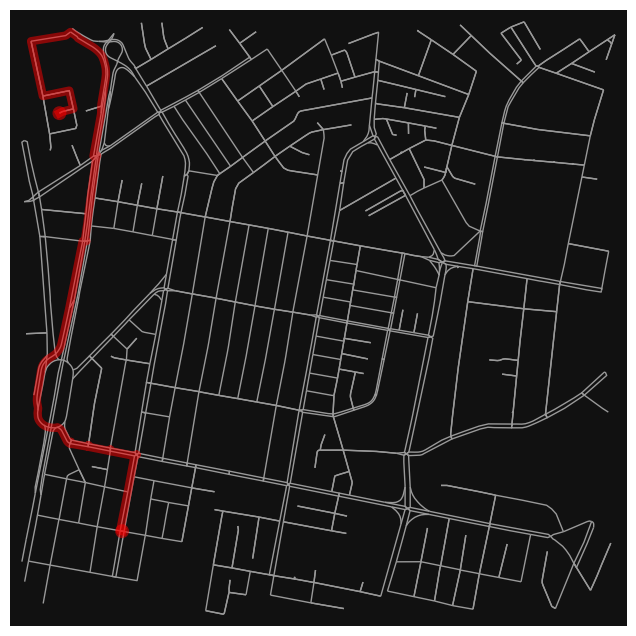

In [25]:
real_path = functions.get_path(route , initial_node)

functions.plot_path(real_path , G)

functions.plot_node(18, 54 , G )

In [13]:
real_path

{76: 78,
 78: 59,
 59: 58,
 58: 60,
 60: 61,
 61: 69,
 69: 71,
 71: 72,
 72: 162,
 162: 152,
 152: 150,
 150: 167,
 167: 176,
 176: 178,
 178: 178}

In [10]:
# def plot_node(node_i , node_f, G ): 
#     """ Function to plot just the path I am interested in. If just want to se the node then put the node two times """
#     route00_G3 = nx.shortest_path(G, node_i, node_f )
    
#     #Plot routes  
#     fig, ax = ox.plot_graph_route(G, route00_G3, route_linewidth=6, node_size=0)



# def get_path (route , initial_node): 
    
#     """function to filter the final real path. Get rio off the non exit-nodes"""

#     # empty path dict to store max probabilities
#     real_path = {}

#     for node in route:
#         if len(route[node]) > 0: 
#             real_path[node] = max(route[node] , key= route[node].get)

#     #store initial node  
#     current_node = real_path.pop(initial_node)

#     # store final paht 
#     filtered_dictionary = {}

#     for node, next_node in real_path.items(): 
#         if node == current_node:
            
#             filtered_dictionary[node] = next_node
#             current_node = next_node
            
#     return filtered_dictionary




# def plot_path (route , G):
#     """" function that plots the path followed by the agent """
#     routes_g = []
#     for n in list(route.keys()):
#         route_G = nx.shortest_path(G, n, n)
#         routes_g.append(route_G)

#     fig, ax = ox.plot_graph_routes(G, routes_g, route_linewidth=6, node_size=0)



# def get_length(node_i , neighbour, G ):
#     """
#     Function to get the lenght between the nodes
#     """
#     # convert to dataframe 
#     df = nx.to_pandas_edgelist(G)

#     # filter by source 
#     filtered_data = df.loc[df['source'] == node_i ]

#     # filter by target
#     filtered_data_target = filtered_data.loc[filtered_data['target'] == neighbour]

#     # get the length in meters 
#     length = filtered_data_target['length'].values[0]

#     return length/1000
